### Motivation
I'm working on a larger project where I need to be able to count syllables and find rhyming words for words that don't appear in the dictionary. (Think proper-nouns and made up words.) Being able to predict how words are pronounced is going to be useful for both tasks. I thought it'd be nice to document my soultion and process. 

I'm hoping this will be useful for beginners and people with more experience. I've done my best to explain my choices while providing links to background info. I wanted the code to be easy to follow so in a few cases brevity and efficiency are sacrificed for readability. Everything is done in python3 & Keras. Let's get started!

### Contents
1. [Dataset](#Dataset)
2. [Data Preparation](#Data-Preparation)
3. [Baseline Model](#Baseline-Model)
     - Training
     - Prediction
     - Evaluation
4. [Character & Phoneme Embeddings](#Character-&-Phoneme-Embeddings)
    - Training
    - Evaluation
    - Visualizing the Embeddings
5. [Bidirectional Encoder & Attention Mechanism](#Bidirectional-Encoder-&-Attention-Decoder)
    - Training
    - Evaluation
    - Final Training & Evaluation
6. [Beamsearch](#Beamsearch)
7. [Results](#Results)
    - Sampling Incorrect Predictions
    - Ideas for Further Improvement
    - Advanced Techniques
    - Acknowledgements

# Dataset
We'll use the [CMU Pronunciation Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict) which maps 134,000 words to their phonetic spellings. For example, "apple" appears in the dictionary as: "AE1 P AH0 L". Each token, without numbers (AE, P, AH, etc.), represents a sound and is called "phoneme." The numbers on the end of some phonemes represent how much ephasis the sound gets. These numbers are  referred to as "lexical stress markers." There are 39 unique phonemes and 84 unique symbols since only vowel sounds have stress markers.

Let's load the dictionary and do a little data cleaning while we're at it:

In [1]:
import re
import os
import random
import numpy as np

# To make sure our kernel runs all the way through and gets saved,
# we'll trim some things back and skip training
LOAD_MODELS = True 

CMU_DICT_PATH = os.path.join(
    './', 'cmu-pronunciation-dictionary-unmodified-07b', 'cmudict-0.7b')
CMU_SYMBOLS_PATH = os.path.join(
    './', 'cmu-pronouncing-dictionary', 'cmudict.symbols')

# Skip words with numbers or symbols
ILLEGAL_CHAR_REGEX = "[^A-Z-'.]"

# Only 3 words are longer than 20 chars
# Setting a limit now simplifies training our model later
MAX_DICT_WORD_LEN = 20
MIN_DICT_WORD_LEN = 2


def load_clean_phonetic_dictionary():

    def is_alternate_pho_spelling(word):
        # No word has > 9 alternate pronounciations so this is safe
        return word[-1] == ')' and word[-3] == '(' and word[-2].isdigit() 

    def should_skip(word):
        if not word[0].isalpha():  # skip symbols
            return True
        if word[-1] == '.':  # skip abbreviations
            return True
        if re.search(ILLEGAL_CHAR_REGEX, word):
            return True
        if len(word) > MAX_DICT_WORD_LEN:
            return True
        if len(word) < MIN_DICT_WORD_LEN:
            return True
        return False

    phonetic_dict = {}
    with open(CMU_DICT_PATH, encoding="ISO-8859-1") as cmu_dict:
        for line in cmu_dict:

            # Skip commented lines
            if line[0:3] == ';;;':
                continue

            word, phonetic = line.strip().split('  ')

            # Alternate pronounciations are formatted: "WORD(#)  F AH0 N EH1 T IH0 K"
            # We don't want to the "(#)" considered as part of the word
            if is_alternate_pho_spelling(word):
                word = word[:word.find('(')]

            if should_skip(word):
                continue

            if word not in phonetic_dict:
                phonetic_dict[word] = []
            phonetic_dict[word].append(phonetic)

    if LOAD_MODELS: # limit dataset to 5,000 words
        phonetic_dict = {key:phonetic_dict[key] 
                         for key in random.sample(list(phonetic_dict.keys()), 5000)}
    return phonetic_dict

phonetic_dict = load_clean_phonetic_dictionary()
example_count = np.sum([len(prons) for _, prons in phonetic_dict.items()])

Let's take a peek at our dictionary:

In [2]:
print("\n".join([k+' --> '+phonetic_dict[k][0] for k in random.sample(list(phonetic_dict.keys()), 10)]))
print('\nAfter cleaning, the dictionary contains %s words and %s pronunciations (%s are alternate pronunciations).' % 
      (len(phonetic_dict), example_count, (example_count-len(phonetic_dict))))

JEFFRIES --> JH EH1 F R IY0 Z
TRISTRAM --> T R IH1 S T R AH0 M
BRZEZINSKI --> B R IH0 Z IH1 N S K IY0
HOROVITZ --> HH AA1 R AH0 V IH0 T S
PUNCHING --> P AH1 N CH IH0 NG
KROUSE --> K R AW1 S
FLICKS --> F L IH1 K S
DEHERRERA --> D EY0 HH EH0 R EH1 R AH0
LOWMAN --> L OW1 M AH0 N
JETSONS --> JH EH1 T S AH0 N Z

After cleaning, the dictionary contains 5000 words and 5333 pronunciations (333 are alternate pronunciations).


# Data Preparation
Next, before we can do any learning, we need to come up with a way to numerically represent words and pronunciations. We'll treat words as squences of characters and pronunciations as sequences of phoneme symbols (including lexical stress markers). We can assign each character and each phoneme a number. Later we'll use these numbers to represent chars/phonemes as 1-hot vectors. Predicting phonemes from a word's letters is sometimes referred to as grapheme-to-phoneme conversion.

We'll need to tell our model where a phonetic spelling starts and ends so we'll introduce 2 special start & end symbols, arbitrarily represented by the tab and newline characters. 

In [3]:
import string

START_PHONE_SYM = '\t'
END_PHONE_SYM = '\n'


def char_list():
    allowed_symbols = [".", "-", "'"]
    uppercase_letters = list(string.ascii_uppercase)
    return [''] + allowed_symbols + uppercase_letters


def phone_list():
    phone_list = [START_PHONE_SYM, END_PHONE_SYM]
    with open(CMU_SYMBOLS_PATH) as file:
        for line in file: 
            phone_list.append(line.strip())
    return [''] + phone_list


def id_mappings_from_list(str_list):
    str_to_id = {s: i for i, s in enumerate(str_list)} 
    id_to_str = {i: s for i, s in enumerate(str_list)}
    return str_to_id, id_to_str


# Create character to ID mappings
char_to_id, id_to_char = id_mappings_from_list(char_list())

# Load phonetic symbols and create ID mappings
phone_to_id, id_to_phone = id_mappings_from_list(phone_list())

# Example:
print('Char to id mapping: \n', char_to_id)

Char to id mapping: 
 {'': 0, '.': 1, '-': 2, "'": 3, 'A': 4, 'B': 5, 'C': 6, 'D': 7, 'E': 8, 'F': 9, 'G': 10, 'H': 11, 'I': 12, 'J': 13, 'K': 14, 'L': 15, 'M': 16, 'N': 17, 'O': 18, 'P': 19, 'Q': 20, 'R': 21, 'S': 22, 'T': 23, 'U': 24, 'V': 25, 'W': 26, 'X': 27, 'Y': 28, 'Z': 29}


It might be tempting to just use these id's as inputs for our model. But doing so implies a relationship between the letters/phonemes that doesn't really exist. For example, since A=4, C=6, and U=24 the implication is that A and C are somehow more alike than A and U (since 4 is closer to 6). This is obviously not the case. Instead, we can use our id mappings to convert chars and phonemes to [1-hot vectors](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/):

In [4]:
CHAR_TOKEN_COUNT = len(char_to_id)
PHONE_TOKEN_COUNT = len(phone_to_id)


def char_to_1_hot(char):
    char_id = char_to_id[char]
    hot_vec = np.zeros((CHAR_TOKEN_COUNT))
    hot_vec[char_id] = 1.
    return hot_vec


def phone_to_1_hot(phone):
    phone_id = phone_to_id[phone]
    hot_vec = np.zeros((PHONE_TOKEN_COUNT))
    hot_vec[phone_id] = 1.
    return hot_vec

# Example:
print('"A" is represented by:\n', char_to_1_hot('A'), '\n-----')
print('"AH0" is represented by:\n', phone_to_1_hot('AH0'))

"A" is represented by:
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] 
-----
"AH0" is represented by:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Now that we have a way to numerically represent letters and sounds (phonemes), we can convert our entire dataset into two, big 3D matricies (tensors):

In [5]:
MAX_CHAR_SEQ_LEN = max([len(word) for word, _ in phonetic_dict.items()])
MAX_PHONE_SEQ_LEN = max([max([len(pron.split()) for pron in pronuns]) 
                         for _, pronuns in phonetic_dict.items()]
                       ) + 2  # + 2 to account for the start & end tokens we need to add


def dataset_to_1_hot_tensors():
    char_seqs = []
    phone_seqs = []
    
    for word, pronuns in phonetic_dict.items():
        word_matrix = np.zeros((MAX_CHAR_SEQ_LEN, CHAR_TOKEN_COUNT))
        for t, char in enumerate(word):
            word_matrix[t, :] = char_to_1_hot(char)
        for pronun in pronuns:
            pronun_matrix = np.zeros((MAX_PHONE_SEQ_LEN, PHONE_TOKEN_COUNT))
            phones = [START_PHONE_SYM] + pronun.split() + [END_PHONE_SYM]
            for t, phone in enumerate(phones):
                pronun_matrix[t,:] = phone_to_1_hot(phone)
                
            char_seqs.append(word_matrix)
            phone_seqs.append(pronun_matrix)
    
    return np.array(char_seqs), np.array(phone_seqs)
            

char_seq_matrix, phone_seq_matrix = dataset_to_1_hot_tensors()        
print('Word Matrix Shape: ', char_seq_matrix.shape)
print('Pronunciation Matrix Shape: ', phone_seq_matrix.shape)

Word Matrix Shape:  (5333, 18, 30)
Pronunciation Matrix Shape:  (5333, 19, 87)


# Baseline Model

Since we're dealing with sequence data, an **RNN**[[video](https://www.coursera.org/learn/nlp-sequence-models/lecture/ftkzt/recurrent-neural-network-model),[blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)] a good choice. Let's start with an **LSTM**[[video](https://www.coursera.org/learn/nlp-sequence-models/lecture/KXoay/long-short-term-memory-lstm),[blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)] based RNN.

Notice that the number of characters in a word is often not the same as the number of phonemes in a pronunciation. There's no 1-to-1 mapping between our inputs and outputs. For that reason, we'll create a **sequence to sequence**[[blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)] model with 2 parts, an encoder and a decoder. 

We'll feed our word representations to the encoder one character at a time and then pass the encoder's state variables to the decoder. We need slightly different decoder setups for training vs. test time. During training, we'll feed the decoder the correct pronunciations, one phoneme at a time. At each timestep, the decoder will predict the next phoneme. During inference (test time), we don't know the correct phoneme sequence (at least in theory). So we'll feed the decoder's output from the previous time step into the next timestep as input. This is why we needed the `START_PHONE_SYM` mentioned earlier. Here's an illustration of how our network will work at test time: 

![](https://i.imgur.com/vzkiAnZ.png)

The `phone_seq_matrix` we created above will be the input to our decoder. We'll create the decoder output by shifting all the phone sequences to the left by 1 step. The decoder outputs won't contain the start token:

In [6]:
phone_seq_matrix_decoder_output = np.pad(phone_seq_matrix,((0,0),(0,1),(0,0)), mode='constant')[:,1:,:]

In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

def baseline_model(hidden_nodes = 256):
    
    # Shared Components - Encoder
    char_inputs = Input(shape=(None, CHAR_TOKEN_COUNT))
    encoder = LSTM(hidden_nodes, return_state=True)
    
    # Shared Components - Decoder
    phone_inputs = Input(shape=(None, PHONE_TOKEN_COUNT))
    decoder = LSTM(hidden_nodes, return_sequences=True, return_state=True)
    decoder_dense = Dense(PHONE_TOKEN_COUNT, activation='softmax')
    
    # Training Model
    _, state_h, state_c = encoder(char_inputs) # notice encoder outputs are ignored
    encoder_states = [state_h, state_c]
    decoder_outputs, _, _ = decoder(phone_inputs, initial_state=encoder_states)
    phone_prediction = decoder_dense(decoder_outputs)

    training_model = Model([char_inputs, phone_inputs], phone_prediction)
    
    # Testing Model - Encoder
    testing_encoder_model = Model(char_inputs, encoder_states)
    
    # Testing Model - Decoder
    decoder_state_input_h = Input(shape=(hidden_nodes,))
    decoder_state_input_c = Input(shape=(hidden_nodes,))
    decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, decoder_state_h, decoder_state_c = decoder(phone_inputs, initial_state=decoder_state_inputs)
    decoder_states = [decoder_state_h, decoder_state_c]
    phone_prediction = decoder_dense(decoder_outputs)
    
    testing_decoder_model = Model([phone_inputs] + decoder_state_inputs, [phone_prediction] + decoder_states)
    
    return training_model, testing_encoder_model, testing_decoder_model

Using TensorFlow backend.


## Training
First, we'll split off a test set so we can get a fair evaluation of our model's performance later. For demonstration, we'll cut the test size down to just 100 examples.

In [8]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
    
(char_input_train, char_input_test, 
 phone_input_train, phone_input_test, 
 phone_output_train, phone_output_test) = train_test_split(
    char_seq_matrix, phone_seq_matrix, phone_seq_matrix_decoder_output, 
    test_size=TEST_SIZE, random_state=42)

TEST_EXAMPLE_COUNT = char_input_test.shape[0]

Now we'll train our sequence to sequence model until it starts to overfit. We want a model that generalizes well to previously unseen examples so we'll keep the version that has the lowest validation loss. 

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def train(model, weights_path, encoder_input, decoder_input, decoder_output):
    checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)
    stopper = EarlyStopping(monitor='val_loss',patience=3)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.fit([encoder_input, decoder_input], decoder_output,
          batch_size=256,
          epochs=100,
          validation_split=0.2, # Keras will automatically create a validation set for us
          callbacks=[checkpointer, stopper])

In [10]:
BASELINE_MODEL_WEIGHTS = os.path.join(
    './', 'predicting-english-pronunciations-model-weights', 'baseline_model_weights.hdf5')
training_model, testing_encoder_model, testing_decoder_model = baseline_model()
if not LOAD_MODELS:
    train(training_model, BASELINE_MODEL_WEIGHTS, char_input_train, phone_input_train, phone_output_train)

Instructions for updating:
Colocations handled automatically by placer.


## Prediction
During training, at each time step, we fed our decoder the correct ouput from the previous time time step. As previously mentioned, we don't know what the *correct* ouput is at test time, only what the decoder predicted. So we need a different procedure to make predictions:
1. Encode the input word (char sequence) as state vectors using the encoder model.
2. Pass the encoder's state variables to the decoder. 
3. Feed the start token to the decoder to get a phoneme prediction at the first time step.
4. Pass the updated states and 1st phoneme prediction as input to the decoder to get the 2nd predicted phoneme.
5. Pass the updated states and 2nd phoneme into the decoder to get the 3rd phoneme and so on until the decoder predicts a stop token or we hit the maximum pronunciation length

In [11]:
def predict_baseline(input_char_seq, encoder, decoder):
    state_vectors = encoder.predict(input_char_seq) 
    
    prev_phone = np.zeros((1, 1, PHONE_TOKEN_COUNT))
    prev_phone[0, 0, phone_to_id[START_PHONE_SYM]] = 1.
    
    end_found = False 
    pronunciation = '' 
    while not end_found:
        decoder_output, h, c = decoder.predict([prev_phone] + state_vectors)
        
        # Predict the phoneme with the highest probability
        predicted_phone_idx = np.argmax(decoder_output[0, -1, :])
        predicted_phone = id_to_phone[predicted_phone_idx]
        
        pronunciation += predicted_phone + ' '
        
        if predicted_phone == END_PHONE_SYM or len(pronunciation.split()) > MAX_PHONE_SEQ_LEN: 
            end_found = True
        
        # Setup inputs for next time step
        prev_phone = np.zeros((1, 1, PHONE_TOKEN_COUNT))
        prev_phone[0, 0, predicted_phone_idx] = 1.
        state_vectors = [h, c]
        
    return pronunciation.strip()

Let's do a quick manual sanity check to see how our model is doing:

In [12]:
# Helper method for converting vector representations back into words
def one_hot_matrix_to_word(char_seq):
    word = ''
    for char_vec in char_seq[0]:
        if np.count_nonzero(char_vec) == 0:
            break
        hot_bit_idx = np.argmax(char_vec)
        char = id_to_char[hot_bit_idx]
        word += char
    return word


# Some words have multiple correct pronunciations
# If a prediction matches any correct pronunciation, consider it correct.
def is_correct(word,test_pronunciation):
    correct_pronuns = phonetic_dict[word]
    for correct_pronun in correct_pronuns:
        if test_pronunciation == correct_pronun:
            return True
    return False


def sample_baseline_predictions(sample_count, word_decoder):
    sample_indices = random.sample(range(TEST_EXAMPLE_COUNT), sample_count)
    for example_idx in sample_indices:
        example_char_seq = char_input_test[example_idx:example_idx+1]
        predicted_pronun = predict_baseline(example_char_seq, testing_encoder_model, testing_decoder_model)
        example_word = word_decoder(example_char_seq)
        pred_is_correct = is_correct(example_word, predicted_pronun)
        print('✅ ' if pred_is_correct else '❌ ', example_word,'-->', predicted_pronun)

In [13]:
training_model.load_weights(BASELINE_MODEL_WEIGHTS)  # also loads weights for testing models
sample_baseline_predictions(30, one_hot_matrix_to_word)

❌  RECOGNISE --> R IY0 K AO1 G N AY2 Z
✅  SEASE --> S IY1 Z
❌  BUESCHER --> B UW1 SH ER0
✅  SCHMOKE --> SH M OW1 K
✅  ALTUS --> AE1 L T AH0 S
❌  ZAVODNY --> Z AA0 V AA1 D N IY0
❌  MALEFACTORS --> M AE2 L AH0 F AE1 K T ER0 Z
❌  MANSEAU --> M AE1 N S UW2
❌  JAMIESON --> JH EY1 M IY0 AH0 S
✅  KIDDE --> K IH1 D
❌  KANAN --> K AE1 N AH0 N
✅  ENLISTING --> EH0 N L IH1 S T IH0 NG
✅  COOVER --> K UW1 V ER0
❌  GUADAGNO --> G W AA2 D AA1 G AH0 N
❌  SCISSOR --> S IH1 S ER0
✅  EYESHADE --> AY1 SH EY2 D
✅  BLOWN --> B L OW1 N
❌  EKATERINA --> EH2 K AH0 T IH1 R IY0 AH0 N
✅  CARICO --> K AA0 R IY1 K OW0
❌  MCADOW --> M AH0 K D AW1
✅  BABBLING --> B AE1 B AH0 L IH0 NG
✅  SLINGERLAND --> S L IH1 NG G ER0 L AH0 N D
✅  DIPRIMA --> D IH0 P R IY1 M AH0
❌  KENNEBREW --> K EH1 N AH0 B R UW2
❌  AUDITORY --> AO1 D AH0 T AO2 R IY0
❌  CARPORTS --> K AA1 R P ER0 T S
✅  COLM --> K OW1 L M
✅  NASHBURG --> N AE1 SH B ER0 G
✅  KINGTON --> K IH1 NG T AH0 N
✅  SINGLES --> S IH1 NG G AH0 L Z


These all look pretty good. Even the incorrect predictions seem reasonable.

## Evaluation
We'll use 3 different metrics to evaluate our model. 

**1. Syllable Count Accuracy**: remember one of the original goals of this project was to be able to count the number of syllables for words not found in the dictionary. Getting a syllable count from a phonetic spelling is as easy as counting the phonemes with stress markers: 

In [14]:
def syllable_count(phonetic_sp): 
    count = 0
    for phone in phonetic_sp.split(): 
        if phone[-1].isdigit():
            count += 1 
    return count

# Examples:
for ex_word in list(phonetic_dict.keys())[:3]:
    print(ex_word, '--', syllable_count(phonetic_dict[ex_word][0]), 'syllables')

NONLINEAR -- 4 syllables
MOONIE -- 2 syllables
KUHNLE -- 2 syllables


**2. Perfect Accuracy**: % of test examples where every predicted phoneme and stress marker is correct and in the correct order. 

**3. Average Bleu Score:** will give our model credit for predictions that are close. A perfect prediction is a 1.0 and a total mismatch is a 0.0. This metric is often used to evaluate language translation, which, if you think about it, is pretty similar to pronunciation prediction. Read more about it [here](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).

In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def is_syllable_count_correct(word, test_pronunciation):
    correct_pronuns = phonetic_dict[word]
    for correct_pronun in correct_pronuns:
        if syllable_count(test_pronunciation) == syllable_count(correct_pronun):
            return True
    return False
    
    
def bleu_score(word,test_pronunciation):
    references = [pronun.split() for pronun in phonetic_dict[word]]
    smooth = SmoothingFunction().method1
    return sentence_bleu(references, test_pronunciation.split(), smoothing_function=smooth)


def evaluate(test_examples, encoder, decoder, word_decoder, predictor):
    correct_syllable_counts = 0
    perfect_predictions = 0
    bleu_scores = []
    
    for example_idx in range(TEST_EXAMPLE_COUNT):
        example_char_seq = test_examples[example_idx:example_idx+1]
        predicted_pronun = predictor(example_char_seq, encoder, decoder)
        example_word = word_decoder(example_char_seq)
        
        perfect_predictions += is_correct(example_word,predicted_pronun)
        correct_syllable_counts += is_syllable_count_correct(example_word,predicted_pronun)

        bleu = bleu_score(example_word,predicted_pronun)
        bleu_scores.append(bleu)
        
    syllable_acc = correct_syllable_counts / TEST_EXAMPLE_COUNT
    perfect_acc = perfect_predictions / TEST_EXAMPLE_COUNT
    avg_bleu_score = np.mean(bleu_scores)
    
    return syllable_acc, perfect_acc, avg_bleu_score


def print_results(model_name, syllable_acc, perfect_acc, avg_bleu_score):
    print(model_name)
    print('-'*20)
    print('Syllable Accuracy: %s%%' % round(syllable_acc*100, 1))
    print('Perfect Accuracy: %s%%' % round(perfect_acc*100, 1))
    print('Bleu Score: %s' % round(avg_bleu_score, 4))

In [16]:
syllable_acc, perfect_acc, avg_bleu_score = evaluate(
    char_input_test, testing_encoder_model, testing_decoder_model, one_hot_matrix_to_word, predict_baseline)
print_results('Baseline Model',syllable_acc, perfect_acc, avg_bleu_score)

Baseline Model
--------------------
Syllable Accuracy: 93.9%
Perfect Accuracy: 57.0%
Bleu Score: 0.6937


Great! Our scores so far are decent. Let's see if we can find a few ways to improve on our baseline model. 

Before we do, let's free up some memory by removing our baseline model from the Tensorflow graph:

In [17]:
from keras import backend as K
K.clear_session()

# Character & Phoneme Embeddings
Instead of representing letters and phonemes as 1-hot vectors, we can use an **embedding**[[video](https://www.coursera.org/learn/nlp-sequence-models/lecture/K604Z/embedding-matrix),[blog](https://www.quora.com/What-is-word-embedding-in-deep-learning)] so our model will learn it's own representations of each symbol. Embeddings are more descriptive representations than 1-hot vectors. Think about how the letter 'c' sometimes sounds like a 'k' and other times sounds like an 's'. In theory, our embedding layer should learn these kinds of relationships. Hopefully this will help improve our scores.

Keras's `Embedding` layer will convert id's to embeddings for us so we need to change the way we represent our word data. This time we'll just store character & phoneme ids instead of their 1-hot representations. For simplicity, we'll continue to use the 1-hot representation of phonemes for our decoders's output layer.

In [18]:
def dataset_for_embeddings():
    char_seqs = []
    phone_seqs = []
    
    for word,pronuns in phonetic_dict.items():
        word_matrix = np.zeros((MAX_CHAR_SEQ_LEN))
        for t,char in enumerate(word):
            word_matrix[t] = char_to_id[char]
        for pronun in pronuns:
            pronun_matrix = np.zeros((MAX_PHONE_SEQ_LEN))
            phones = [START_PHONE_SYM] + pronun.split() + [END_PHONE_SYM]
            for t, phone in enumerate(phones):
                pronun_matrix[t] = phone_to_id[phone]
                
            char_seqs.append(word_matrix)
            phone_seqs.append(pronun_matrix)
    
    return np.array(char_seqs), np.array(phone_seqs)

            
char_emb_matrix, phone_emb_matrix = dataset_for_embeddings()        

print('Embedding Word Matrix Shape: ', char_emb_matrix.shape)
print('Embedding Phoneme Matrix Shape: ', phone_emb_matrix.shape)

Embedding Word Matrix Shape:  (5333, 18)
Embedding Phoneme Matrix Shape:  (5333, 19)


We need to redo the train/test split. Notice that `random_state` is the same as before so the examples in each set will be the same. It also means we don't need to redo the split for our 1-hot (decoder output) phoneme matrix since we're reusing it.

In [19]:
(emb_char_input_train, emb_char_input_test, 
 emb_phone_input_train, emb_phone_input_test) = train_test_split(
    char_emb_matrix, phone_emb_matrix, test_size=TEST_SIZE, random_state=42)

Finally we can add the new embedding layers to our baseline model. Since they add a lot more trainable parameters to our network it's going to be easier to overfit. Let's try to avoid that by adding a few dropout layers:

In [20]:
from keras.layers import Embedding, Dropout, Activation

def embedding_model(hidden_nodes = 256, emb_size = 256):
    
    # Shared Components - Encoder
    char_inputs = Input(shape=(None,))
    char_embedding_layer = Embedding(CHAR_TOKEN_COUNT, emb_size, input_length=MAX_CHAR_SEQ_LEN, mask_zero=True)
    encoder = LSTM(hidden_nodes, return_state=True, recurrent_dropout=0.1)
    
    # Shared Components - Decoder
    phone_inputs = Input(shape=(None,))
    phone_embedding_layer = Embedding(PHONE_TOKEN_COUNT, emb_size, mask_zero=True)
    decoder = LSTM(hidden_nodes, return_sequences=True, return_state=True, recurrent_dropout=0.1)
    decoder_dense = Dense(PHONE_TOKEN_COUNT, activation='softmax')
    
    # Training Model
    char_embeddings = char_embedding_layer(char_inputs)
    char_embeddings = Activation('relu')(char_embeddings)
    char_embeddings = Dropout(0.5)(char_embeddings)
    _, state_h, state_c = encoder(char_embeddings)
    encoder_states = [state_h, state_c]
    
    phone_embeddings = phone_embedding_layer(phone_inputs)
    phone_embeddings = Activation('relu')(phone_embeddings)
    phone_embeddings = Dropout(0.5)(phone_embeddings)
    decoder_outputs, _, _ = decoder(phone_embeddings, initial_state=encoder_states)
    decoder_outputs = Dropout(0.5)(decoder_outputs)
    phone_outputs = decoder_dense(decoder_outputs)

    training_model = Model([char_inputs, phone_inputs], phone_outputs)
    
    # Testing Model - Encoder
    testing_encoder_model = Model(char_inputs, encoder_states)
    
    # Testing Model - Decoder
    decoder_state_input_h = Input(shape=(hidden_nodes,))
    decoder_state_input_c = Input(shape=(hidden_nodes,))
    decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
    test_decoder_outputs, decoder_state_h, decoder_state_c = decoder(phone_embeddings, initial_state=decoder_state_inputs)
    decoder_states = [decoder_state_h, decoder_state_c]
    test_phone_outputs = decoder_dense(test_decoder_outputs)
    
    testing_decoder_model = Model([phone_inputs] + decoder_state_inputs, [test_phone_outputs] + decoder_states)
    
    return training_model, testing_encoder_model, testing_decoder_model

## Training (Embedding Model)

In [39]:
EMBEDDING_MODEL_WEIGHTS = os.path.join(
    './', 'predicting-english-pronunciations-model-weights', 'embedding_model_weights.hdf5')
emb_training_model, emb_testing_encoder_model, emb_testing_decoder_model = embedding_model()
if not LOAD_MODELS:
    train(emb_training_model, EMBEDDING_MODEL_WEIGHTS, emb_char_input_train, emb_phone_input_train, phone_output_train)

## Evaluation (Embedding Model)
To evaluate our embedding model we need to add a new helper method to convert id based representations back into words:

In [41]:
def id_vec_to_word(emb_char_seq):
    word = ''
    for char_id in emb_char_seq[0]:
        char = id_to_char[char_id]
        word += char
    return word.strip()

We'll also rewrite the prediction method to work with id representations (instead of 1-hot) before we score our new model:

In [42]:
def predict_emb(input_char_seq, encoder, decoder):
    state_vectors = encoder.predict(input_char_seq) 
    output_phone_seq = np.array([[phone_to_id[START_PHONE_SYM]]])
    
    end_found = False 
    pronunciation = '' 
    while not end_found:
        decoder_output, h, c = decoder.predict([output_phone_seq] + state_vectors)
        
        # Predict the phoneme with the highest probability
        predicted_phone_idx = np.argmax(decoder_output[0, -1, :])
        predicted_phone = id_to_phone[predicted_phone_idx]
        
        pronunciation += predicted_phone + ' '
        
        if predicted_phone == END_PHONE_SYM or len(pronunciation.split()) > MAX_PHONE_SEQ_LEN: 
            end_found = True
        
        # Setup inputs for next time step
        output_phone_seq = np.array([[predicted_phone_idx]])
        state_vectors = [h, c]
        
    return pronunciation.strip()

In [44]:
emb_training_model.load_weights(EMBEDDING_MODEL_WEIGHTS) # also loads weights for testing models
syllable_acc, perfect_acc, avg_bleu_score = evaluate(
    emb_char_input_test, emb_testing_encoder_model, emb_testing_decoder_model, id_vec_to_word, predict_emb)
print_results('Embedding Model', syllable_acc, perfect_acc, avg_bleu_score)

Embedding Model
--------------------
Syllable Accuracy: 97.0%
Perfect Accuracy: 66.0%
Bleu Score: 0.775


Nice! Adding embedding layers and dropout resulted in a solid improvement on all our metrics. 

Let's try out our performance on some random word

In [45]:
predict_word = 'NICK'
predict_char_input = np.array([np.zeros(MAX_CHAR_SEQ_LEN)])
for idx, letter in enumerate(predict_word):
    predict_char_input[0][idx] = char_to_id[letter]
print(predict_word, ':', predict_char_input)

NICK : [[17. 12.  6. 14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [46]:
predict_emb(predict_char_input, emb_testing_encoder_model, emb_testing_decoder_model)

'N IH1 K'

### Visualizing the Embeddings
For fun, let's extract the embeddings the model learned and visualize them with t-SNE:

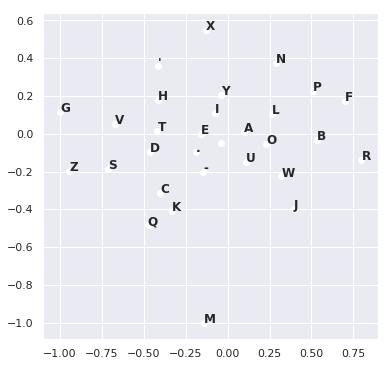

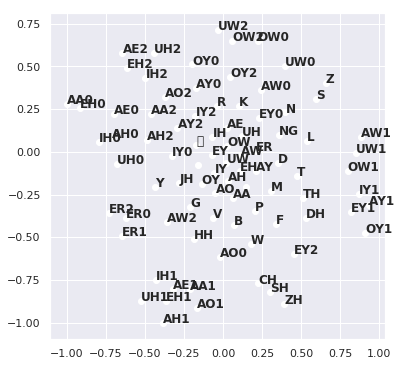

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


def plot_embeddings(embeddings, symbols, perplexity):
    embeddings_in_2D = TSNE(n_components=2,perplexity=perplexity).fit_transform(embeddings)
    embeddings_in_2D[:,0] = embeddings_in_2D[:,0] / np.max(np.abs(embeddings_in_2D[:,0]))
    embeddings_in_2D[:,1] = embeddings_in_2D[:,1] / np.max(np.abs(embeddings_in_2D[:,1]))

    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)
    ax.scatter(embeddings_in_2D[:,0], embeddings_in_2D[:,1],c='w')

    for i, letter in enumerate(symbols):
        ax.annotate(letter, (embeddings_in_2D[i,0],embeddings_in_2D[i,1]), fontsize=12, fontweight='bold')
        
        
char_embedding = emb_training_model.layers[2].get_weights()[0]
plot_embeddings(char_embedding, char_to_id.keys(), 5)

phone_embedding = emb_training_model.layers[3].get_weights()[0]
plot_embeddings(phone_embedding, phone_to_id.keys(), 18)
plt.show()

Pretty cool. Notice how letters and phonemes with similar sounds are grouped together.

Let's reset the Tensorflow graph again and keep going!

In [28]:
K.clear_session()

# Bidirectional Encoder & Attention Decoder
Up to this point, our RNN models have only run in one direction and the only connection between our encoder and decoder has been the 2 state variables we pass between them (from end of the encoder --> start of the decoder). For longer words & pronunciations, those state variables might not be enough to capture the entire word and the singal from the encoder has the potential to get lost. 

An Attention Mechanism[video,blog] is a way to avoid this problem. We'll need to make some big changes to our model's structure. We'll be using the encoder's outputs instead of it's internal state variables. This makes it easy to make the encoder bidirectional[video,blog]. Having info about the next as well as the previous characters in a word should result in better encodings at each time step.

In [29]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Multiply, Reshape, RepeatVector, Lambda, Flatten
from keras.activations import softmax

def attention_model(hidden_nodes = 256, emb_size = 256):
    # Attention Mechanism Layers
    attn_repeat = RepeatVector(MAX_CHAR_SEQ_LEN)
    attn_concat = Concatenate(axis=-1)
    attn_dense1 = Dense(128, activation="tanh")
    attn_dense2 = Dense(1, activation="relu")
    attn_softmax = Lambda(lambda x: softmax(x,axis=1))
    attn_dot = Dot(axes = 1)
    
    def get_context(encoder_outputs, h_prev):
        h_prev = attn_repeat(h_prev)
        concat = attn_concat([encoder_outputs, h_prev])
        e = attn_dense1(concat)
        e = attn_dense2(e)
        attention_weights = attn_softmax(e)
        context = attn_dot([attention_weights, encoder_outputs])
        return context
    
    # Shared Components - Encoder
    char_inputs = Input(shape=(None,))
    char_embedding_layer = Embedding(CHAR_TOKEN_COUNT, emb_size, input_length=MAX_CHAR_SEQ_LEN)
    encoder = Bidirectional(LSTM(hidden_nodes, return_sequences=True, recurrent_dropout=0.2))
    
    # Shared Components - Decoder
    decoder = LSTM(hidden_nodes, return_state=True, recurrent_dropout=0.2)
    phone_embedding_layer = Embedding(PHONE_TOKEN_COUNT, emb_size)
    embedding_reshaper = Reshape((1,emb_size,))
    context_phone_concat = Concatenate(axis=-1)
    context_phone_dense = Dense(hidden_nodes*3, activation="relu")
    output_layer = Dense(PHONE_TOKEN_COUNT, activation='softmax')
    
    # Training Model - Encoder
    char_embeddings = char_embedding_layer(char_inputs)
    char_embeddings = Activation('relu')(char_embeddings)
    char_embeddings = Dropout(0.5)(char_embeddings)
    encoder_outputs = encoder(char_embeddings)
    
    # Training Model - Attention Decoder
    h0 = Input(shape=(hidden_nodes,))
    c0 = Input(shape=(hidden_nodes,))
    h = h0 # hidden state
    c = c0 # cell state
    
    phone_inputs = []
    phone_outputs = []
    
    for t in range(MAX_PHONE_SEQ_LEN):
        phone_input = Input(shape=(None,))
        phone_embeddings = phone_embedding_layer(phone_input)
        phone_embeddings = Dropout(0.5)(phone_embeddings)
        phone_embeddings = embedding_reshaper(phone_embeddings)
        
        context = get_context(encoder_outputs, h)
        phone_and_context = context_phone_concat([context, phone_embeddings])
        phone_and_context = context_phone_dense(phone_and_context)
        
        decoder_output, h, c = decoder(phone_and_context, initial_state = [h, c])
        decoder_output = Dropout(0.5)(decoder_output)
        phone_output = output_layer(decoder_output)
        
        phone_inputs.append(phone_input)
        phone_outputs.append(phone_output)
    
    training_model = Model(inputs=[char_inputs, h0, c0] + phone_inputs, outputs=phone_outputs)
    
   # Testing Model - Encoder
    testing_encoder_model = Model(char_inputs, encoder_outputs)

    # Testing Model - Decoder
    test_prev_phone_input = Input(shape=(None,))
    test_phone_embeddings = phone_embedding_layer(test_prev_phone_input)
    test_phone_embeddings = embedding_reshaper(test_phone_embeddings)
    
    test_h = Input(shape=(hidden_nodes,), name='test_h')
    test_c = Input(shape=(hidden_nodes,), name='test_c')
    
    test_encoding_input = Input(shape=(MAX_CHAR_SEQ_LEN, hidden_nodes*2,))
    test_context = get_context(test_encoding_input, test_h)
    test_phone_and_context = Concatenate(axis=-1)([test_context, test_phone_embeddings])
    test_phone_and_context = context_phone_dense(test_phone_and_context)
        
    test_seq, out_h, out_c = decoder(test_phone_and_context, initial_state = [test_h, test_c])
    test_out = output_layer(test_seq)
    
    testing_decoder_model = Model([test_prev_phone_input, test_h, test_c, test_encoding_input], [test_out,out_h,out_c])
    
    return training_model, testing_encoder_model, testing_decoder_model

## Training (Attention Model)
Since our model, inputs, and outputs have changed so much from our 2 previous versions we need to slightly rewrite our traing procedure. We'll still stop when we start to overfit or plateau and we'll keep the weights that achieve the best validation set loss.

In [30]:
def train_attention(model, weights_path, validation_size=0.2, epochs=100):    
    h0 = np.zeros((emb_char_input_train.shape[0], 256))
    c0 = np.zeros((emb_char_input_train.shape[0], 256))
    inputs = list(emb_phone_input_train.swapaxes(0,1))
    outputs = list(phone_output_train.swapaxes(0,1))
    
    callbacks = []
    if validation_size > 0:
        checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)
        stopper = EarlyStopping(monitor='val_loss',patience=3)
        callbacks = [checkpointer, stopper]

    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.fit([emb_char_input_train, h0, c0] + inputs, outputs,
              batch_size=256,
              epochs=epochs,
              validation_split=validation_size,
              callbacks=callbacks)
    
    if validation_size == 0:
        model.save_weights(weights_path)

In [31]:
ATTENTION_MODEL_WEIGHTS = os.path.join(
    './', 'predicting-english-pronunciations-model-weights', 'attention_model_weights.hdf5')
attn_training_model, attn_testing_encoder_model, attn_testing_decoder_model = attention_model()
if not LOAD_MODELS:
    train_attention(attn_training_model, ATTENTION_MODEL_WEIGHTS)

## Evaluation (Attention Model)
We also need to make some modifications to our baseline_predict method to get it working with our attention model:

In [32]:
def predict_attention(input_char_seq, encoder, decoder):
    encoder_outputs = encoder.predict(input_char_seq) 

    output_phone_seq = np.array([[phone_to_id[START_PHONE_SYM]]])
    
    h = np.zeros((emb_char_input_train.shape[0], 256))
    c = np.zeros((emb_char_input_train.shape[0], 256))
    
    end_found = False 
    pronunciation = '' 
    while not end_found:
        decoder_output, h, c = decoder.predict([output_phone_seq, h, c, encoder_outputs])
        
        # Predict the phoneme with the highest probability
        predicted_phone_idx = np.argmax(decoder_output[0,:])
        predicted_phone = id_to_phone[predicted_phone_idx]
        
        pronunciation += predicted_phone + ' '
        
        if predicted_phone == END_PHONE_SYM or len(pronunciation.split()) > MAX_PHONE_SEQ_LEN: 
            end_found = True
        
        # Setup inputs for next time step
        output_phone_seq = np.array([[predicted_phone_idx]])
        
    return pronunciation.strip()

In [33]:
attn_training_model.load_weights(ATTENTION_MODEL_WEIGHTS) # also loads weights for testing models
syllable_acc, perfect_acc, avg_bleu_score = evaluate(
    emb_char_input_test, attn_testing_encoder_model, attn_testing_decoder_model, id_vec_to_word, predict_attention)
print_results('Attention Model', syllable_acc, perfect_acc, avg_bleu_score)

Attention Model
--------------------
Syllable Accuracy: 98.3%
Perfect Accuracy: 72.8%
Bleu Score: 0.8143


Awesome, all that extra work appears to have paid off. Again we managed a solid improvement in all of our metrics. 

## Final Training and Evaluation
Now that we know which model works best, how long we can train it before it overfits, and all our other hyper-parameters tuned, let's train one final model on all of our training data. 

In [34]:
K.clear_session()
FINAL_ATTENTION_MODEL_WEIGHTS = os.path.join(
    './', 'predicting-english-pronunciations-model-weights', 'final_attention_model_weights.hdf5')
attn_training_model, attn_testing_encoder_model, attn_testing_decoder_model = attention_model()
if not LOAD_MODELS:
    train_attention(attn_training_model, FINAL_ATTENTION_MODEL_WEIGHTS, validation_size=0.0, epochs=29)

In [35]:
attn_training_model.load_weights(FINAL_ATTENTION_MODEL_WEIGHTS) # also loads weights for testing models
syllable_acc, perfect_acc, avg_bleu_score = evaluate(
    emb_char_input_test, attn_testing_encoder_model, attn_testing_decoder_model, id_vec_to_word, predict_attention)
print_results('Final Attention Model', syllable_acc, perfect_acc, avg_bleu_score)

Final Attention Model
--------------------
Syllable Accuracy: 98.6%
Perfect Accuracy: 75.5%
Bleu Score: 0.8308


Our numbers are looking pretty good, but we've still got 1 trick left up our sleeve...

# Beamsearch
So far, when we make predictions, we choose the phoneme with the highest probability at each timestep and then move on. But what we *really* want is the sequence of phonemes with the highest probability overall. If we make the wrong choice early on, we can easily end up with a less-than-optimal prediction and we'd never know it! One solution would be to search the entire output space and choose the best of all possible sequences. This would guarantee we find the most likely sequence (at least according to our model) but would take *forever* and involve a lot of wasted effort.

Instead we can use Beamsearch[[video](https://www.coursera.org/learn/nlp-sequence-models/lecture/4EtHZ/beam-search),[blog](https://hackernoon.com/beam-search-a-search-strategy-5d92fb7817f)] which sort of falls between the two extremes. At each timestep, we keep the *k* most likely sequences and the move on. Increasing the value of *k* means we're more likely to find the optimal sequence but increases the search time. 

In [36]:
def predict_beamsearch(input_char_seq, encoder, decoder, k=4):
    a = encoder.predict(input_char_seq) 
    
    s = np.zeros((emb_char_input_train.shape[0], 256))
    c = np.zeros((emb_char_input_train.shape[0], 256))
    
    all_seqs = []
    all_seq_scores = []
    
    live_seqs = [[phone_to_id[START_PHONE_SYM]]]
    live_scores = [0]
    live_states = [[s,c]]

    while len(live_seqs) > 0: 
        new_live_seqs = [] 
        new_live_scores = [] 
        new_live_states = []
        
        for sidx,seq in enumerate(live_seqs):
            target_seq = np.array([[seq[-1]]])
            output_token_probs, s, c = decoder.predict([target_seq] + live_states[sidx] + [a])
            
            best_token_indicies = output_token_probs[0,:].argsort()[-k:]

            for token_index in best_token_indicies:
                new_seq = seq + [token_index]
                prob = output_token_probs[0,:][token_index]
                new_seq_score = live_scores[sidx] - np.log(prob)
                if id_to_phone[token_index] == END_PHONE_SYM or len(new_seq) > MAX_PHONE_SEQ_LEN:
                    all_seqs.append(new_seq) 
                    all_seq_scores.append(new_seq_score) 
                    continue
                new_live_seqs.append(new_seq)
                new_live_scores.append(new_seq_score)
                new_live_states.append([s, c])
                
        while len(new_live_scores) > k:
            worst_seq_score_idx = np.array(new_live_scores).argsort()[-1] 
            del new_live_seqs[worst_seq_score_idx]
            del new_live_scores[worst_seq_score_idx]
            del new_live_states[worst_seq_score_idx]
            
        live_seqs = new_live_seqs
        live_scores = new_live_scores
        live_states = new_live_states
        
    best_idx = np.argmin(all_seq_scores)
    score = all_seq_scores[best_idx]
    
    pronunciation = ''
    for i in all_seqs[best_idx]:
        pronunciation += id_to_phone[i] + ' '
    
    return pronunciation.strip()

In [37]:
syllable_acc, perfect_acc, avg_bleu_score = evaluate(
    emb_char_input_test, attn_testing_encoder_model, attn_testing_decoder_model, id_vec_to_word, predict_beamsearch)
print_results('Final Attention Model + Beamsearch', syllable_acc, perfect_acc, avg_bleu_score)

Final Attention Model + Beamsearch
--------------------
Syllable Accuracy: 98.8%
Perfect Accuracy: 75.2%
Bleu Score: 0.8308


# Results
Here are the final results I obtained locally on the complete test set (~20k examples):

| Model        | Baseline | Embedding | Attention | Final Attention | Final Attention + Beamsearch |
|--------------|----------|-----------|-----------|-----------------|------------------------------|
| Syllable Acc | 91.3        |   96.0        |   96.8        |     97.1            | **98.1**                             |
| Perfect Acc  | 51.9         |    61.5       |    66.6      |     67.6            |   **75.4**                           |
| Bleu Score   | 0.654         |   0.734        |     0.770      |      0.778           | **0.829**                           |

English is a weird language. Even native speakers mis-pronounce words that are new to them. Pronunciation rules are complicated and sometimes don't make any sense. Just check out [this video](https://www.youtube.com/watch?v=1edPxKqiptw) for a few examples. 75.4% accuracy might not seem that high, but all things considered, I think it's a respectable score. 

 ## Sampling Incorrect Predictions
 Let's take a look at some of the words our model is getting wrong:


In [38]:
def display_wrong_predictions(sample_count, word_decoder, encoder, decoder):
    found = 0
    while found < sample_count:
        sample_index = random.sample(range(TEST_EXAMPLE_COUNT), 1)[0]
        example_char_seq = emb_char_input_test[sample_index:sample_index+1]
        predicted_pronun = predict_attention(example_char_seq, encoder, decoder)
        example_word = word_decoder(example_char_seq)
        pred_is_correct = is_correct(example_word,predicted_pronun)
        if not pred_is_correct:
            found += 1
            print('❌ ', example_word,'-->',predicted_pronun)
            
display_wrong_predictions(20, id_vec_to_word, attn_testing_encoder_model, attn_testing_decoder_model)

❌  DITOMMASO --> D IH0 T OW0 M AA1 S OW0
❌  PROGRESSIVELY --> P R AH0 G R EH1 S IH0 V L IY0
❌  AIS --> EY1 Z
❌  GOULASH --> G UW1 L AE2 SH
❌  ARABELLA --> AA2 R AH0 B EH1 L AH0
❌  COLLOPY --> K AA1 L AH0 P IY0
❌  ACRID --> AE1 K R AH0 D
❌  COHENOUR --> K AA1 HH AH0 N UH0 R
❌  ION --> AY1 AA0 N
❌  FRIEDBERG --> F R IY1 D B ER0 G
❌  FEDERMAN --> F EH1 D ER0 M AH0 N
❌  SOCIETAL --> S OW0 S AY1 AH0 T AH0 L
❌  ADVISING --> AH0 D V AY1 Z IH0 NG
❌  ARDMORE --> AA1 R D M AO0 R
❌  COLLOPY --> K AA1 L AH0 P IY0
❌  LOELLA --> L OW0 EH1 L AH0
❌  CORRELATES --> K AO1 R AH0 L EY2 T S
❌  LOELLA --> L OW0 EH1 L AH0
❌  KANAN --> K AE1 N AH0 N
❌  DEGAS --> D IY1 G AH0 S


## Ideas for Further Improvement
* **Using 2 seperate models** Model 1 only predicts the phonemes while model 2 adds the stress markers (numbers) in the appropriate places. Knowing the length of the final sequence means our second model's decoder could easily be bidirectional. Knowing about past *and future* vowel sounds seems likely to improve our stress marker perdictions.
* **More hyper-parameter tuning** we really didn't spend much time tweaking our hyper-parameters. It should be easy to find some better values and inprove our scores.
* **Larger Model** adding another recurrent layer to our encoder and/or decoder or inserting some 1D convolutional layers could be worth trying.
* **More data!** Finding our creating a dataset with more names, places and slang should help.

## Advanced Techniques
This is by no means a state-of-the-art approach to the pronunciation problem. If you're interested in better solutions make sure to check out some of these papers:
* [Predicting Pronunciations with Syllabification and Stress with Recurrent Neural Networks](https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1419.PDF) by Daan van Esch, Mason Chua, Kanishka Rao
* [Text-To-Phoneme Mapping Using Neural Networks](https://tutcris.tut.fi/portal/files/2313141/bilcub.pdf) by Enikö Beatrice Bilcu
* [GRAPHEME-TO-PHONEME CONVERSION USING LONG SHORT-TERM MEMORY RECURRENT NEURAL NETWORKS](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43264.pdf) by Kanishka Rao, Fuchun Peng, Has¸im Sak, Franc¸oise Beaufays
* [Joint-Sequence Models for Grapheme-to-PhonemeConversion](https://hal.archives-ouvertes.fr/hal-00499203/document) by Maximilian Bisani, Hermann Ney

## Acknowledgements
A lot of the ideas applied here came from Andrew Ng's super-awesome [Deep Learning Specialization on Coursera](https://www.coursera.org/specializations/deep-learning).
I used the [Keras Examples](https://github.com/keras-team/keras/tree/master/examples) on Github as a reference for the baseline model. 
I also borrowed some ideas from this [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) for the attention model.